<a href="https://colab.research.google.com/github/anshupandey/MSA-analytics/blob/main/POTMS2/Lab4_Ocean_Hull_Insurance_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⚙️ Optimization Exercises on Ocean Hull Insurance Portfolio

This notebook explores:
- **Exercise 1**: Value-at-Risk (VaR) and Conditional Value-at-Risk (CVaR)
- **Exercise 2**: Portfolio Simulation and Return Projection
- **Exercise 3**: Mean-Variance Optimization

We use the previously generated Ocean Hull Insurance dataset to perform experimental risk analysis.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

## 📥 Load and Explore Dataset

In [ ]:
# Replace with actual path if needed
df = pd.read_csv('https://raw.githubusercontent.com/anshupandey/MSA-analytics/refs/heads/main/datasets/Ocean_Hull_Insurance_datasetv2.csv')
df.head()

,Vessel_ID,Vessel_Type,Operating_Zone,Vessel_Age,Flag_State,Inspection_Status,Weather_Risk,Piracy_Risk,Claim_Occurred,Claim_Amount
0,1,Container Ship,Strait of Malacca,19,Marshall Islands,Overdue,Moderate,Moderate,0,0
1,2,Container Ship,Strait of Malacca,40,Marshall Islands,Up-to-date,High,High,0,0
2,3,Tanker,Indian Ocean,26,Greece,Delayed,Low,Low,0,0
3,4,Bulk Carrier,South China Sea,7,Greece,Up-to-date,Moderate,Low,0,0
4,5,Offshore Support Vessel,Mediterranean,18,Liberia,Delayed,Low,Low,0,0


## 🧪 Exercise 1: Value-at-Risk (VaR) and Conditional Value-at-Risk (CVaR)

📉 95% Value-at-Risk (VaR): ₹2,632,842.00
🔥 Conditional VaR (CVaR): ₹3,308,502.87


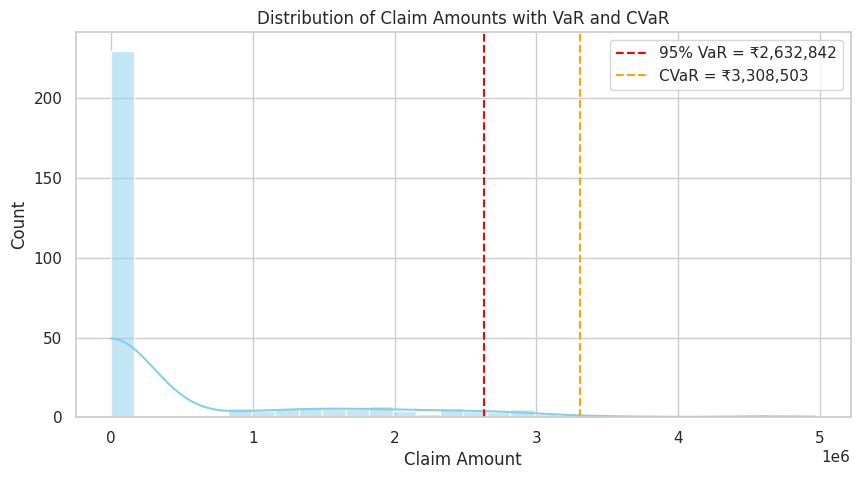

In [ ]:

claim_data = df['Claim_Amount'].copy()
sorted_claims = claim_data.sort_values()

# 95% VaR
var_95 = np.percentile(sorted_claims, 95)

# CVaR: Mean of worst 5%
cvar_95 = sorted_claims[sorted_claims >= var_95].mean()

print("📉 95% Value-at-Risk (VaR): ₹{:,.2f}".format(var_95))
print("🔥 Conditional VaR (CVaR): ₹{:,.2f}".format(cvar_95))

# Plot histogram
plt.figure(figsize=(10,5))
sns.histplot(sorted_claims, bins=30, kde=True, color='skyblue')
plt.axvline(var_95, color='red', linestyle='--', label=f'95% VaR = ₹{var_95:,.0f}')
plt.axvline(cvar_95, color='orange', linestyle='--', label=f'CVaR = ₹{cvar_95:,.0f}')
plt.legend()
plt.title('Distribution of Claim Amounts with VaR and CVaR')
plt.xlabel('Claim Amount')
plt.show()


## 🧪 Exercise 2: Portfolio Simulation and Return Projection

In [ ]:

portfolio_returns = df.groupby('Vessel_Type').agg(
    Total_Invested=('Initial_Investment', 'sum'),
    Final_Value=('Final_Value', 'sum'),
    Mean_Return=('Daily_Return', 'mean'),
    Std_Dev=('Daily_Return', 'std')
)

portfolio_returns['Cumulative_Return_%'] = ((portfolio_returns['Final_Value'] / portfolio_returns['Total_Invested']) - 1) * 100
portfolio_returns


,Total_Invested,Final_Value,Mean_Return,Std_Dev,Cumulative_Return_%
Vessel_Type,,,,,
Bulk Carrier,6872100.0,7.140088e+06,0.000392,0.000867,3.899648
Container Ship,8137200.0,8.636669e+06,0.000617,0.001019,6.138091
Offshore Support Vessel,1999800.0,2.089830e+06,0.000460,0.000786,4.501966
Tanker,11350800.0,1.191962e+07,0.000491,0.001100,5.011266


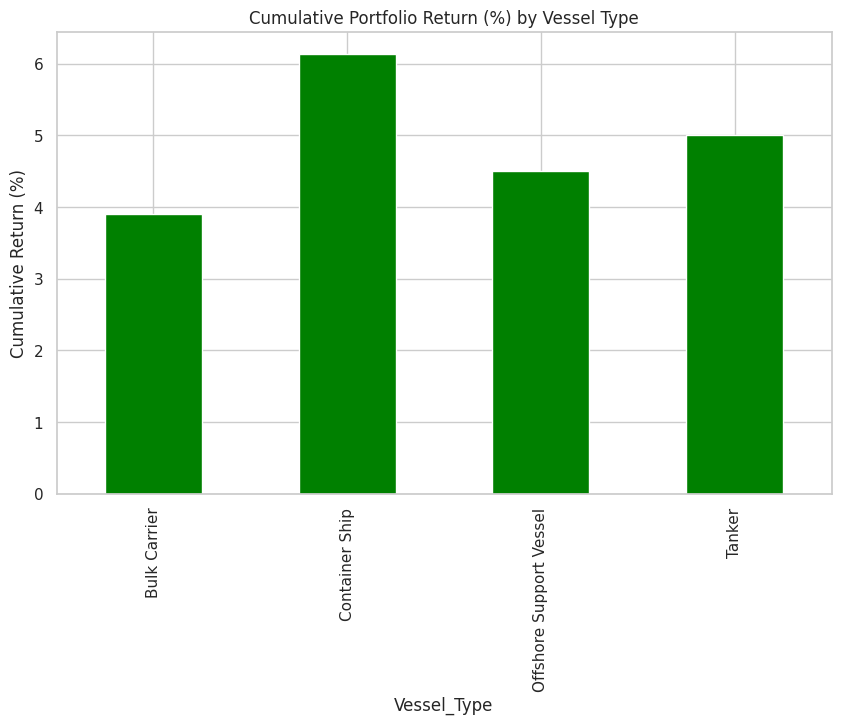

In [ ]:

portfolio_returns['Cumulative_Return_%'].plot(kind='bar', figsize=(10,6), color='green', title='Cumulative Portfolio Return (%) by Vessel Type')
plt.ylabel('Cumulative Return (%)')
plt.grid(True)
plt.show()


## 🧪 Exercise 3: Mean-Variance Optimization

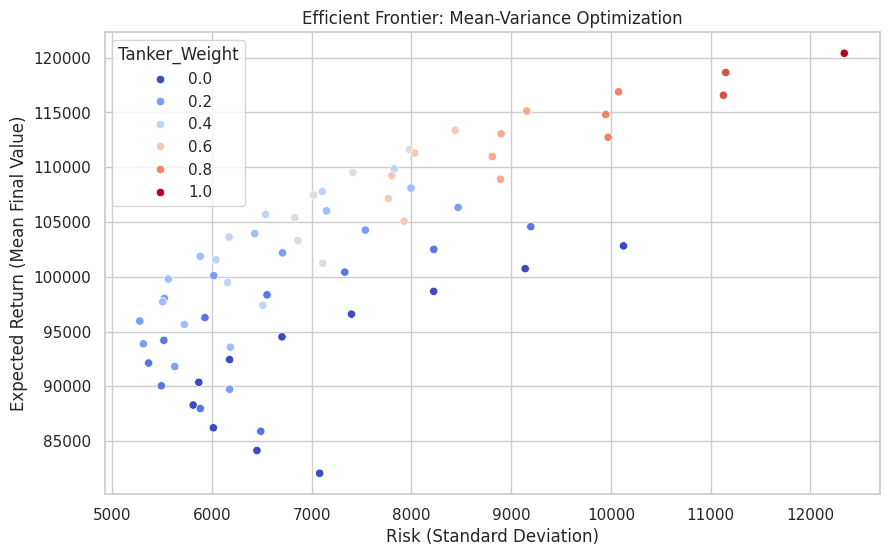

In [ ]:

returns_df = df.groupby('Vessel_Type').agg(
    Mean_Return=('Final_Value', 'mean'),
    Std_Dev=('Final_Value', 'std')
)

# Generate sample weight combinations
weights = np.linspace(0, 1, 11)
results = []

# Try combinations of 3 assets: Tanker, Bulk Carrier, Container Ship
for w1 in weights:
    for w2 in weights:
        if w1 + w2 <= 1:
            w3 = 1 - w1 - w2
            mean_return = (w1 * returns_df.loc['Tanker', 'Mean_Return'] +
                           w2 * returns_df.loc['Bulk Carrier', 'Mean_Return'] +
                           w3 * returns_df.loc['Container Ship', 'Mean_Return'])
            std_dev = np.sqrt((w1**2 * returns_df.loc['Tanker', 'Std_Dev']**2) +
                              (w2**2 * returns_df.loc['Bulk Carrier', 'Std_Dev']**2) +
                              (w3**2 * returns_df.loc['Container Ship', 'Std_Dev']**2))
            results.append((w1, w2, w3, mean_return, std_dev))

opt_df = pd.DataFrame(results, columns=['Tanker_Weight', 'Bulk_Weight', 'Container_Weight', 'Expected_Return', 'Portfolio_Risk'])

# Plot Efficient Frontier
plt.figure(figsize=(10,6))
sns.scatterplot(data=opt_df, x='Portfolio_Risk', y='Expected_Return', hue='Tanker_Weight', palette='coolwarm')
plt.title('Efficient Frontier: Mean-Variance Optimization')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return (Mean Final Value)')
plt.grid(True)
plt.show()



## 📌 Summary of Insights

- **VaR/CVaR** highlighted potential tail risk in claim distributions.
- **Portfolio Simulation** showed performance variance across vessel types.
- **Mean-Variance Optimization** offered a visual method to balance return and risk using allocation strategies.

These tools help insurers make data-driven capital allocation decisions.
